# Proyek Klasifikasi Gambar: Alzheimer MRI
- **Nama:** Najwa Salsabila
- **Email:** najwas.for.study@gmail.com
- **ID Dicoding:** najwasalsabila

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflowjs

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 93.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 119.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uni

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
import keras
from tqdm import tqdm
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow import keras
from tensorflow.keras import regularizers
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import glob
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## Data Preparation

### Data Loading

In [3]:
import kagglehub
import os

# == DOWNLOAD DATASET ==
path = kagglehub.dataset_download("uraninjo/augmented-alzheimer-mri-dataset")

100%|██████████| 380M/380M [00:08<00:00, 46.0MB/s]

Extracting files...


In [4]:
print("Path to dataset files:", path)
files = os.listdir(path)
print("Files in dataset folder:", files)

Path to dataset files: /root/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset/versions/1
Files in dataset folder: ['AugmentedAlzheimerDataset', 'OriginalDataset']


In [5]:
file_path = os.path.join(path, 'AugmentedAlzheimerDataset')
image_data = file_path

### Data Preprocessing

#### Split Dataset

In [6]:
train_files = [i for i in glob.glob(image_data + '//*//*')]
np.random.shuffle(train_files)
train_labels = [os.path.dirname(i).split('/')[-1] for i in train_files]
train_data = zip(train_files, train_labels)
train_df = pd.DataFrame(train_data, columns=["Image", 'Label'])
train_df.head()

,Image,Label
0,/root/.cache/kagglehub/datasets/uraninjo/augme...,MildDemented
1,/root/.cache/kagglehub/datasets/uraninjo/augme...,NonDemented
2,/root/.cache/kagglehub/datasets/uraninjo/augme...,VeryMildDemented
3,/root/.cache/kagglehub/datasets/uraninjo/augme...,ModerateDemented
4,/root/.cache/kagglehub/datasets/uraninjo/augme...,MildDemented


In [7]:
batch_size = 8
target_size = (224, 224)
test_split = 0.2

all_data = tf.keras.preprocessing.image_dataset_from_directory(
    image_data,
    image_size=target_size,
    batch_size=batch_size
)

dataset_size = tf.data.experimental.cardinality(all_data).numpy()

train_size = int(dataset_size * (1 - test_split))
test_size = dataset_size - train_size

train = all_data.take(train_size)
remaining_data = all_data.skip(train_size)

test = remaining_data.take(test_size)

Found 33984 files belonging to 4 classes.


## Modelling

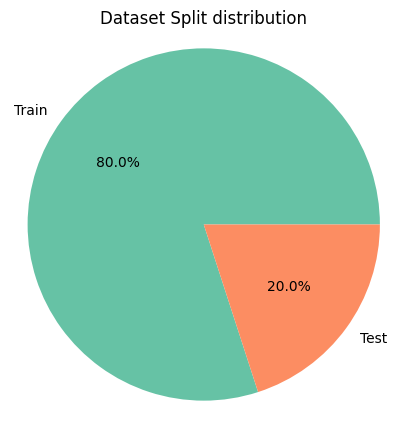

In [8]:
sizes = [train_size, test_size]
labels = ['Train', 'Test']
colors = ['#66c2a5', '#fc8d62']

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title('Dataset Split distribution')
plt.axis('equal')
plt.show()

(8, 224, 224, 3)
(8,)


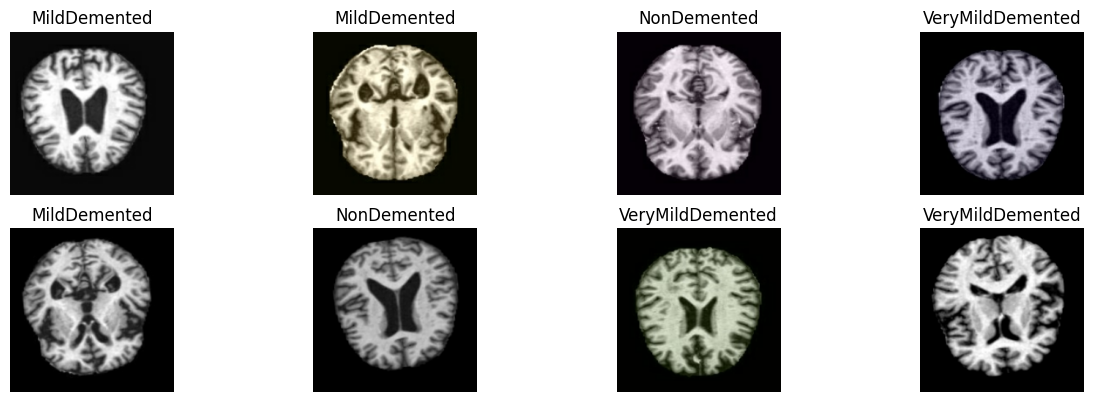

In [9]:
class_names = all_data.class_names

plt.figure(figsize=(15, 20))
num_images_per_class = 4
count = {class_name : 0 for class_name in class_names}

for images, labels in train.take(1):
    print(images.shape)
    print(labels.shape)
    for i in range(len(labels)):
        label = class_names[labels[i]]

        if count[label] < num_images_per_class:
            ax = plt.subplot(8, 4, sum(count.values()) + 1)
            plt.imshow(images[i].numpy().astype('uint8'))
            plt.title(label)
            plt.axis('off')
            count[label] += 1

        if sum(count.values()) >= num_images_per_class * len(class_names):
            break

In [10]:
all_data.class_names

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [11]:
keras_model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])

keras_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 257,860 (1007.27 KB)

 Trainable params: 257,860 (1007.27 KB)

 Non-trainable params: 0 (0.00 B)

## Evaluasi dan Visualisasi

In [12]:
checkpoint = ModelCheckpoint('model.keras', save_best_only=True)

keras_model.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [13]:
history = keras_model.fit(
    train,
    epochs=50,
    validation_data=test,
    callbacks=[checkpoint]
)

Epoch 1/50
3398/3398 ━━━━━━━━━━━━━━━━━━━━ 77s 21ms/step - accuracy: 0.3336 - loss: 1.3990 - val_accuracy: 0.5981 - val_loss: 0.8551
Epoch 2/50
3398/3398 ━━━━━━━━━━━━━━━━━━━━ 69s 20ms/step - accuracy: 0.5996 - loss: 0.8689 - val_accuracy: 0.6091 - val_loss: 0.7832
Epoch 3/50
3398/3398 ━━━━━━━━━━━━━━━━━━━━ 68s 20ms/step - accuracy: 0.6668 - loss: 0.7270 - val_accuracy: 0.6854 - val_loss: 0.6951
Epoch 4/50
3398/3398 ━━━━━━━━━━━━━━━━━━━━ 69s 20ms/step - accuracy: 0.7227 - loss: 0.6081 - val_accuracy: 0.7422 - val_loss: 0.5813
Epoch 5/50
3398/3398 ━━━━━━━━━━━━━━━━━━━━ 88s 26ms/step - accuracy: 0.7744 - loss: 0.5016 - val_accuracy: 0.8034 - val_loss: 0.4410
Epoch 6/50
3398/3398 ━━━━━━━━━━━━━━━━━━━━ 69s 20ms/step - accuracy: 0.8178 - loss: 0.4131 - val_accuracy: 0.8362 - val_loss: 0.4185
Epoch 7/50
3398/3398 ━━━━━━━━━━━━━━━━━━━━ 69s 20ms/step - accuracy: 0.8487 - loss: 0.3603 - val_accuracy: 0.8257 - val_loss: 0.4713
Epoch 8/50
3398/3398 ━━━━━━━━━━━━━━━━━━━━ 83s 21ms/step - accuracy: 0.8758 -

In [31]:
keras_model.save("model.keras")

In [32]:
keras_model.save("model.h5")

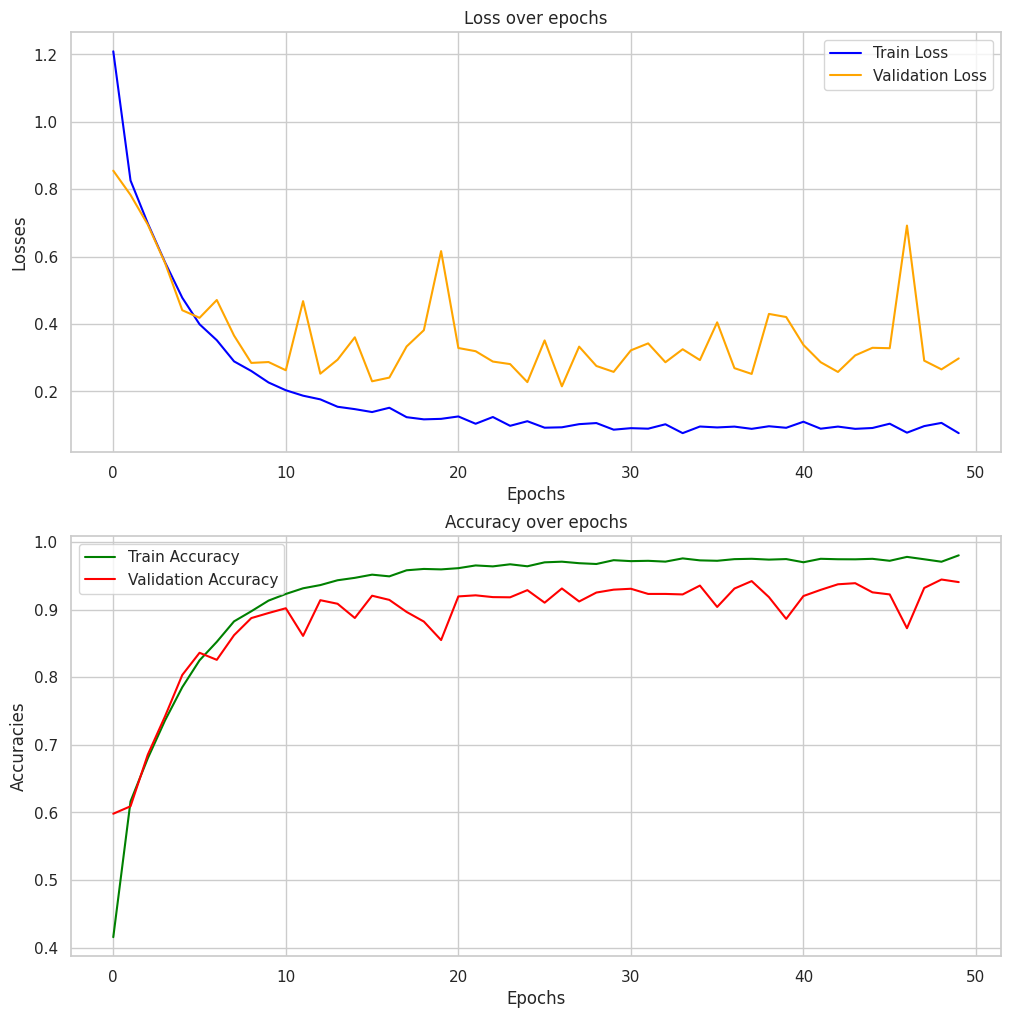

In [15]:
sns.set(style='whitegrid')
fig, axs = plt.subplots(2, figsize=(12, 12))

axs[0].plot(history.history['loss'], label='Train Loss', color='blue')
axs[0].plot(history.history['val_loss'], label='Validation Loss', color='orange')
axs[0].set_title('Loss over epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Losses')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(history.history['accuracy'], label='Train Accuracy', color='green')
axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[1].set_title("Accuracy over epochs")
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracies')
axs[1].legend()
axs[1].grid(True)

## Konversi Model

In [16]:
import tensorflow as tf

# Load the best Keras model
model = tf.keras.models.load_model('model.keras')

save_path = 'mymodel/'
tf.saved_model.save(model, save_path)

In [20]:
keras_model = tf.keras.models.load_model('/content/model.keras')
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
tflite_model = converter.convert()
with open('tflite_model.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmpspb1zog9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  139410775700080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139410775125408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139410777766576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139410775426144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139410775438112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139410774991344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139410774992576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139410776548528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139410779056160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139410819881744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139410815317648

In [21]:
labels = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
with open('label.txt', 'w') as f:
    for label in labels:
        f.write(label + '\n')

In [37]:
# !tensorflowjs_converter --input_format=keras /content/model.keras tfjs_model
!tfjs.converters.save_keras_model(/content/model.keras, tfjs_model)

/bin/bash: -c: line 1: syntax error near unexpected token `/content/model.keras,'
/bin/bash: -c: line 1: `tfjs.converters.save_keras_model(/content/model.keras, tfjs_model)'


## Inference (Optional)

In [23]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import files
from IPython.display import Image, display

Upload gambar untuk diprediksi:


Saving images (1).jpg to images (1).jpg


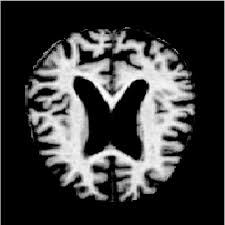

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step
Predictions (Raw): [[0.24454185 0.03831431 0.18892407 0.52821976]]
Predicted Class Index: 3
Predicted Class Name: VeryMildDemented


In [24]:
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

model = tf.keras.models.load_model('/content/model.keras')

print("Upload gambar untuk diprediksi:")
uploaded = files.upload()

image_path = list(uploaded.keys())[0]

display(Image(image_path))

input_image = preprocess_image(image_path)

predictions = model.predict(input_image)

print("Predictions (Raw):", predictions)

predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_class_name = class_names[predicted_class_index]
print(f"Predicted Class Index: {predicted_class_index}")
print(f"Predicted Class Name: {predicted_class_name}")
